# Datavalanche

## Exploratory data analysis of the SLF deadly avalanche dataset

In [61]:
%load_ext autoreload
%autoreload 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date
import folium
from folium import plugins
%aimport helpers
import pygrib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
def parsedate(ts):
    return date.fromtimestamp(int(ts))

data = pd.read_csv('data/avalanches.csv', parse_dates=['date_posix_ts'], date_parser=parsedate)

In [40]:
data.head()

,winter,date_posix_ts,canton,community,starting_zone_Y,starting_zone_X,elevation,aspect_id,aspect_string,activity,victims,caught,buried,danger_level
0,2015/16,2016-07-04,VS,Baltschieder,631760,138570,3440,5,E,1,1,2,0,0
1,2015/16,2016-05-05,GR,Flims,737700,197340,2900,6,ESE,1,1,1,1,0
2,2015/16,2016-04-29,VS,Naters,640290,146390,3680,11,SW,1,1,2,1,2
3,2015/16,2016-04-20,GR,Sils im Engadin/Segl,781510,135430,2810,3,NE,1,1,1,1,3
4,2015/16,2016-04-19,VS,Orsières,570830,93228,3100,2,NNE,2,1,2,1,3


Let's see how many deadly avalanches occurred each year during the last 20 years

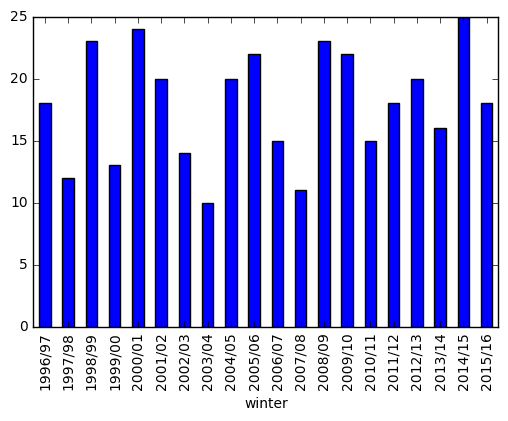

In [41]:
avalanches_per_winter = data.groupby('winter').count()['canton']
avalanches_per_winter.plot(kind='bar')

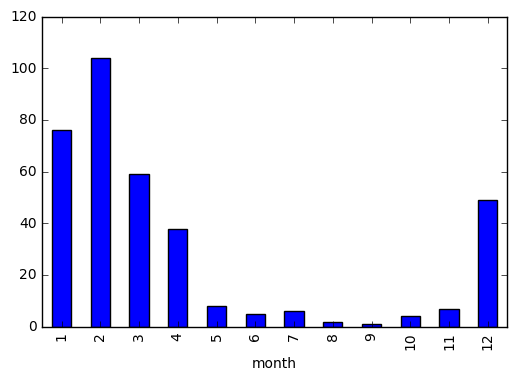

In [42]:
data['month'] = data['date_posix_ts'].map(lambda x: x.month)
avalanches_per_month = data.groupby('month').count()['canton']
avalanches_per_month.plot(kind='bar')

In [43]:
data.groupby(['winter', 'month']).count()['canton']

winter   month
1996/97  1         3
         2        12
         5         1
         7         1
         12        1
1997/98  1         5
         3         2
         4         1
         10        1
         12        3
1998/99  1         3
         2         9
         3         1
         4         2
         6         1
         7         1
         10        1
         12        5
1999/00  1         1
         2         4
         3         1
         4         2
         9         1
         11        1
         12        3
2000/01  1         4
         2        12
         3         3
         5         2
         6         1
                  ..
2011/12  2         6
         4         5
         12        5
2012/13  1         3
         2         6
         3         4
         4         3
         10        1
         11        1
         12        2
2013/14  1         2
         2         3
         3         1
         7         2
         8         1
         12        

TODO: we should try to compare this with data about total quantities of snow per year/month !


Let's now look at the aspect of the slopes where the avalanches occurred.

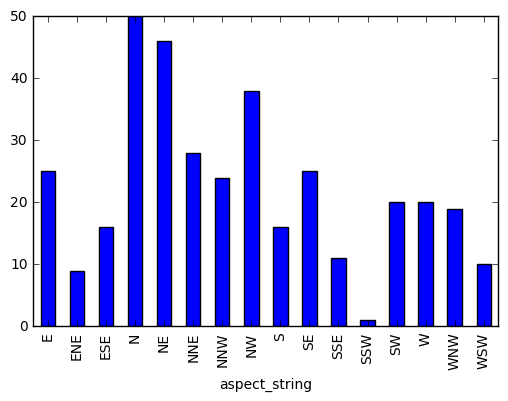

In [44]:
avalanches_per_aspect = data.groupby('aspect_string').count()['canton']
avalanches_per_aspect.plot(kind='bar')

It seems that north facing slopes are more dangerous. TODO: statistical test ?

Avalanches per danger level: TODO compare this with average proportion of days with given danger level during a winter (we should be abl to find this on the SLF website)

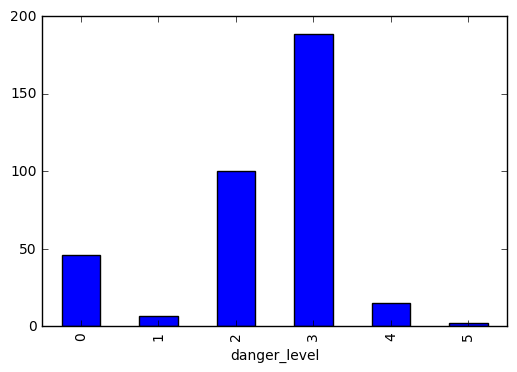

In [45]:
avalanches_per_danger = data.groupby('danger_level').count()['canton']
avalanches_per_danger.plot(kind='bar')

Let's see the distribution of avalanche starting point elevation

Mean avalanche start point elevation: 2519.9526462395543


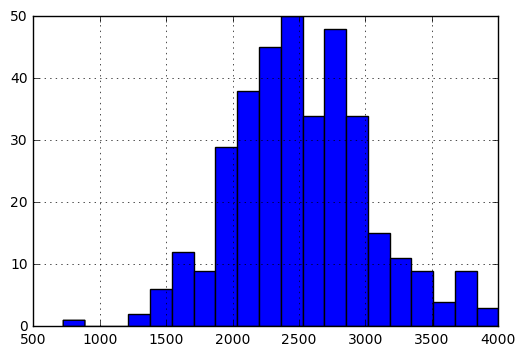

In [46]:
print('Mean avalanche start point elevation:', data['elevation'].mean())
data['elevation'].hist(bins=20)

Mean avalanche start point elevation: 2755.869918699187


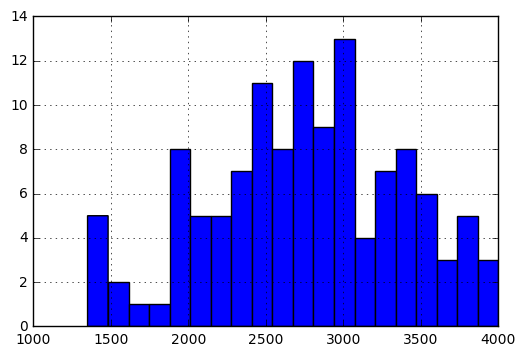

In [47]:
# TODO: maybe not so useful...
# Usually we don't go at high altitudes during the winter.
# Let's see if the mean altitude changes when not taking into account winter months
filtered_elevations = data[(data['month'] > 2) & (data['month'] < 11)]['elevation']
print('Mean avalanche start point elevation:', filtered_elevations.mean())
filtered_elevations.hist(bins=20)

# TODO: Some fancy map with avalanches per canton :D ?

In [48]:
# Get number of avalanches per canton
missing_cantons = ['ZH', 'ZG', 'SO', 'BS', 'BL', 'SH', 'JU', 'GE', 'NE','TG', 'AR', 'AG']
avalanches_per_canton = data.groupby('canton').count()[['winter']]
avalanches_per_canton.columns = [['count']]
avalanches_per_canton['count'] = avalanches_per_canton['count'].apply(lambda x: 0 if x == 0 else np.log10(x))
avalanches_per_canton = avalanches_per_canton.append(pd.DataFrame({'count':0}, index=missing_cantons))
avalanches_per_canton.reset_index(inplace=True)

In [49]:
topo_path = r'ch-cantons.topojson.json'
# Create map with log number of avalanches per canton 
av_per_canton_map = folium.Map(location=[46.8, 8.239], zoom_start=8)
av_per_canton_map.choropleth(geo_path = topo_path, data=avalanches_per_canton,
                     columns=['index', 'count'], 
                     key_on='feature.id',
                     fill_color='PuRd', fill_opacity=0.7, line_opacity=0.2,
                     topojson='objects.cantons')
av_per_canton_map

KeyError: 'index'

In [50]:
# Change the stupid coordinate system in latitude/longitude
for i in data.index:
    x = data.starting_zone_X[i]
    y = data.starting_zone_Y[i]
    lat = helpers.CHtoWGSlat(x, y)
    lng = helpers.CHtoWGSlng(x, y)
    data.set_value(i, 'lat', lat)
    data.set_value(i, 'lon', lng)
    
data.drop(['starting_zone_X','starting_zone_Y'], axis=1).head()

,winter,date_posix_ts,canton,community,elevation,aspect_id,aspect_string,activity,victims,caught,buried,danger_level,month,lat,lon
0,2015/16,2016-07-04,VS,Baltschieder,3440,5,E,1,1,2,0,0,7,46.397737,7.851589
1,2015/16,2016-05-05,GR,Flims,2900,6,ESE,1,1,1,1,0,5,46.912888,9.246352
2,2015/16,2016-04-29,VS,Naters,3680,11,SW,1,1,2,1,2,4,46.467623,7.963174
3,2015/16,2016-04-20,GR,Sils im Engadin/Segl,2810,3,NE,1,1,1,1,3,4,46.345707,9.796747
4,2015/16,2016-04-19,VS,Orsières,3100,2,NNE,2,1,2,1,3,4,45.989984,7.062188


In [51]:
# Count the number of avalanches per community
d2 = data[['community', 'lat', 'lon']]
cnt = d2.groupby('community').count()[['lat']]
cnt.columns = ['count']
avalanches_per_community = pd.concat([d2.groupby('community').first(), cnt], axis=1)
avalanches_per_community.head()

,lat,lon,count
community,,,
Adelboden,46.447069,7.511086,7
Aeschi bei Spiez,46.595959,7.768668,1
Airolo,46.565699,8.544159,1
Alt St Johann,47.200112,9.256064,1
Altstätten,47.287387,9.511861,1


In [52]:
# Create a heat_map of avalanches
avalanches_heat_map = folium.Map(location=[46.8, 8.239], zoom_start=8, tiles='Mapbox Bright', )
avalanches_heat_map.choropleth(geo_path = topo_path, topojson='objects.cantons', fill_opacity=0.3, line_opacity=0.7), 
avalanches_heat_map_vals = avalanches_per_community.as_matrix()
avalanches_heat_map.add_children(plugins.HeatMap(avalanches_heat_map_vals, radius = 17))

most = avalanches_per_community.sort_values(by='count', ascending=False).head(10)
for index, row in most.iterrows():
    location = [row['lat'], row['lon']]
    folium.Marker(location = location, popup=index, icon = folium.Icon(color ='red')).add_to(avalanches_heat_map)
    
avalanches_heat_map

In [53]:
most

,lat,lon,count
community,,,
Davos,46.673589,9.764923,16
Zermatt,46.023963,7.632350,14
Nendaz,46.112423,7.314119,13
Anniviers,46.240161,7.616576,11
Bagnes,46.051662,7.212281,10
Orsières,45.989984,7.062188,8
Lauterbrunnen,46.556468,7.848783,8
Adelboden,46.447069,7.511086,7
Pontresina,46.417681,9.971442,6


Idea:
 - Create a more interactive map with sliders to select year/month and buttons to chose what the heatmap is about: number of victims, buried etc..   

In [103]:
#read the meteorological data
davos_df = pd.read_pickle('./data/pickle/davos_df.pkl')
zermatt_df = pd.read_pickle('./data/pickle/davos_df.pkl')
nendaz_df = pd.read_pickle('./data/pickle/_df.pkl')
anniviers_df = pd.read_pickle('./data/pickle/_df.pkl')
bagnes_df = pd.read_pickle('./data/pickle/_df.pkl')
orsieres_df = pd.read_pickle('./data/pickle/_df.pkl')
lauterbrunnen_df = pd.read_pickle('./data/pickle/_df.pkl')
adelboden_df = pd.read_pickle('./data/pickle/_df.pkl')
pontresina_df = pd.read_pickle('./data/pickle/_df.pkl')
evolene_df = pd.read_pickle('./data/pickle/_df.pkl')



FileNotFoundError: [Errno 2] No such file or directory: './data/pickle/_df.pkl'